# New collaborations are driven by experienced lead authors

## Brief overview

Another reason for new collaborations might be the effect of leading authors. Most collaborations require a clear leadership from a single author, may it be the person requesting funding, the most experienced author or the person that understands the bigger picture of the project at hand. We assume that if lead authors are experienced, they often have a clearly defined network of people who they have already collaborated with. In addition to that, these lead authors also drive ground-breaking research and create new collaborations. However, with their drive for new innovations they are also motivated to search for new collaborations and can often bring their own team or past collaborators to form new connections along the way.

Using the number of articles published by lead author as a proxy of experience, we test the correlation between lead author experience and collaboration novelty by building a linear model.

**Key takeaways:**

### Imports & Global Variables

In [30]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from box import Box
from util.postgres import create_sqlalchemy_connection, query

In [31]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_connection = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)
sns.set_theme(style="whitegrid", palette="pastel")

## Querying the data

Query the author experience and collaboration novelty by article.

In [4]:
sql_query = """
WITH article_by_novelty AS (SELECT article_id,
                                   is_new_collaboration
                            FROM fct_article)
SELECT n.article_id,
       c.author_article_count                             AS author_experience,
       CASE WHEN n.is_new_collaboration THEN 1 ELSE 0 END AS is_new_collaboration
FROM article_by_novelty n
         INNER JOIN fct_collaboration c
                    ON n.article_id = c.article_id
                        AND c.author_sequence_type = 'lastAuthor'
"""

df = query(conn=pg_connection, query_str=sql_query)

## Testing lead author experience impact on collaboration novelty

Given an article, we extract its lead author as the last author signed on the article. We realize this might not be the case for some articles but assume the majority of sciences follows the convention of the lead author being signed as the last author on the publication. We define the notion of author experience $E$ of author $a_i$ as:
$E_i=|P_i|$, where $P_i$ are all publications from author $a_i$.

Next, we define the target variable as $Y=\{0, 1\}$, where $Y=0$ corresponds with the given article $p$ being an existing collaboration, whereas $Y=1$ correspnds with article $p$ being a new collaboration.

From this, we can build a linear model: $Y \sim \beta \cdot E + \alpha$ and if $\beta$ is positive, we can deduce that more experienced lead authors bring more new collaborations, making them more heterogeneous and at the same time very influential to all collaborations.

**NULL HYPOTHESIS** $H_0$: $\beta <= 0$

In [83]:
df_filtered = df.copy()  # Create an explicit copy to avoid warnings
author_experience_percentile_2_5 = df['author_experience'].quantile(0.025)
author_experience_percentile_97_5 = df['author_experience'].quantile(0.975)
df_filtered = df_filtered[
    (df_filtered['author_experience'] > author_experience_percentile_2_5) & 
    (df_filtered['author_experience'] < author_experience_percentile_97_5)
]
author_mean = df_filtered["author_experience"].mean()
author_std = df_filtered["author_experience"].std()

df_filtered["author_experience_std"] = (df_filtered["author_experience"] - author_mean) / author_std

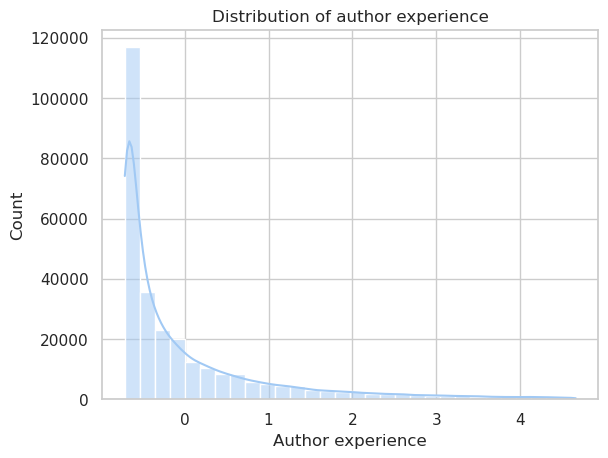

In [84]:
sns.histplot(data=df_filtered, x='author_experience_std', bins=30, kde=True)
plt.title(f'Distribution of author experience')
plt.xlabel('Author experience')
plt.show()

In [86]:
# Sample the data so that we'll have a balanced dataset over collabroation types
n_new_collaborations = df_filtered['is_new_collaboration'].sum()
n_existing_collaborations = df_filtered.shape[0] - n_new_collaborations
min_collaboration_count = min(n_new_collaborations, n_existing_collaborations)
print(f'Number of new collaborations: {n_new_collaborations}')
print(f'Number of existing collaborations: {n_existing_collaborations}')

# Sample the dataframe to a balanced dataset
df_positive = df_filtered[df_filtered['is_new_collaboration'] == 1].sample(n=min_collaboration_count)
df_negative = df_filtered[df_filtered['is_new_collaboration'] == 0].sample(n=min_collaboration_count)
df_sampled = pd.concat([df_positive, df_negative])
df_sampled.head(5)

Number of new collaborations: 253082
Number of existing collaborations: 27771


,article_id,author_experience,is_new_collaboration,author_experience_std
342091,85075069301,4,1,-0.610853
2737,79952110930,2,1,-0.678864
94598,85113492262,60,1,1.293472
64395,84864475026,41,1,0.647362
358388,85070549373,67,1,1.531512


In [87]:
print(df_sampled["author_experience"].describe())
print(df_sampled["is_new_collaboration"].value_counts())

count    55542.000000
mean        24.819272
std         30.793474
min          1.000000
25%          4.000000
50%         12.000000
75%         34.000000
max        159.000000
Name: author_experience, dtype: float64
is_new_collaboration
1    27771
0    27771
Name: count, dtype: int64


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 147 seconds.


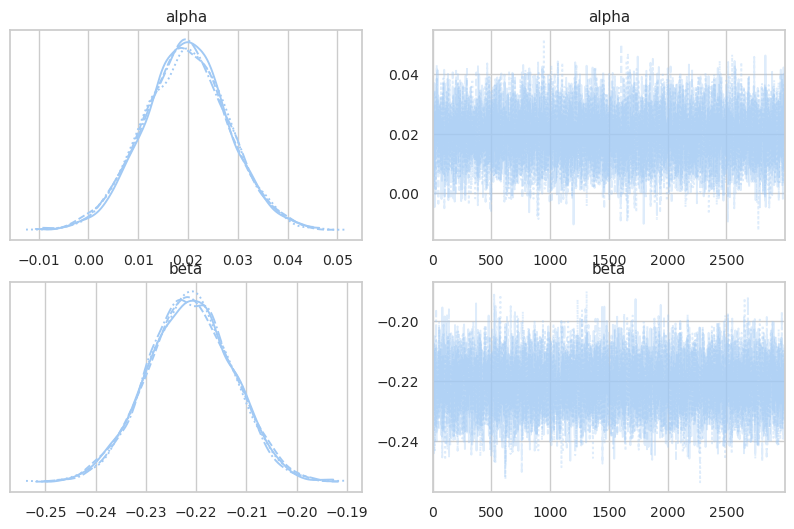

In [88]:
with pm.Model() as logistic_model:
    # Priors on intercept & slope (normal distr. because they supposedly work better on long-tail distributions)
    alpha = pm.Normal("alpha", mu=0.0, sigma=10)
    beta  = pm.Normal("beta", mu=0.0, sigma=10)

    # Linear predictor
    mu = alpha + beta * df_sampled["author_experience_std"].values

    # Convert to probability via the logistic function
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    
    # Observed data
    y_obs = pm.Bernoulli("y_obs", p=p, observed=df_sampled["is_new_collaboration"].values)

    # Sample from the posterior
    trace = pm.sample(
        draws=3000,  # post-warmup draws
        tune=1000,  # warmup (tuning) draws
        target_accept=0.90,
        random_seed=42,
        progressbar=True
    )

# Plot the trace and posterior distributions for alpha, beta
az.plot_trace(trace, var_names=["alpha", "beta"], figsize=(10, 6))
plt.show()

In [90]:
# Summary of posterior
az.summary(trace, var_names=["alpha", "beta"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.020,0.008,0.003,0.037,0.0,0.0,11040.0,8441.0,1.0
beta,-0.221,0.008,-0.238,-0.205,0.0,0.0,11059.0,7714.0,1.0


In [93]:
# Transform beta to the original scale
beta_from_trace = float(trace.posterior['beta'].mean(dim=["chain", "draw"]))
alpha_from_trace = float(trace.posterior['alpha'].mean(dim=["chain", "draw"]))
beta_original = beta_from_trace / author_std
alpha_original = alpha_from_trace - beta_original * author_mean

print(f"Alpha={round(alpha_original, 4)}, Alpha (std)={round(alpha_from_trace, 4)}")
print(f"Beta={round(beta_original, 4)}, Beta (std)={round(beta_from_trace, 4)}")

Alpha=0.1847, Alpha (std)=0.0195
Beta=-0.0075, Beta (std)=-0.2212


## (optional) Author collaborativeness

Additionally we can also evaluate and understand how prone lead authors are to external collaborations. To do this, we derive a simple metric called collaborativeness rate. We formulate the collaborativeness rate by checking how many of all publications are collaborations. If this proportion is high, we can assume that lead authors are prone to inviting people from other institutions to collaborate.

**NOT IMPLEMENTED**